# Demonstration: Adjusted $R^2$ and the Fischer Test

First we have our standard header with common import statements, and a statement to make plots look nice.

In [13]:
# standard import statements 2023
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as opt
import classlib4334

# jupyter-specific display instructions
%config InlineBackend.figure_format = 'retina'

# my personal defaults
mpl.rcParams['figure.figsize'] = (5.5, 3.5)
mpl.rcParams['font.size'] = 10
mpl.rcParams['lines.linewidth'] = 3

Again, we'll define a bunch of polynomials:

In [28]:
def p1(x, a, b):
    return a + b*x

def p2(x, a, b, c):
    return a + b*x + c*x**2

def p3(x, a, b, c, d):
    return a + b*x + c*x**2 + d*x**3

def p4(x, a, b, c, d, e):
    return a + b*x + c*x**2 + d*x**3 + e*x**4

def p5(x, a, b, c, d, e, f):
    return a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5

def p6(x, a, b, c, d, e, f, g):
    return a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5 + g*x**6

def p7(x, a, b, c, d, e, f, g, h):
    return a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5 + g*x**6 + h*x**7

## Revisiting Example 2:  Where to stop

We are going to revisit the example from the previous demonstration, and now introduce ways to quantify what we mean by "good enough."  We'll start by loading and visualizing the data:

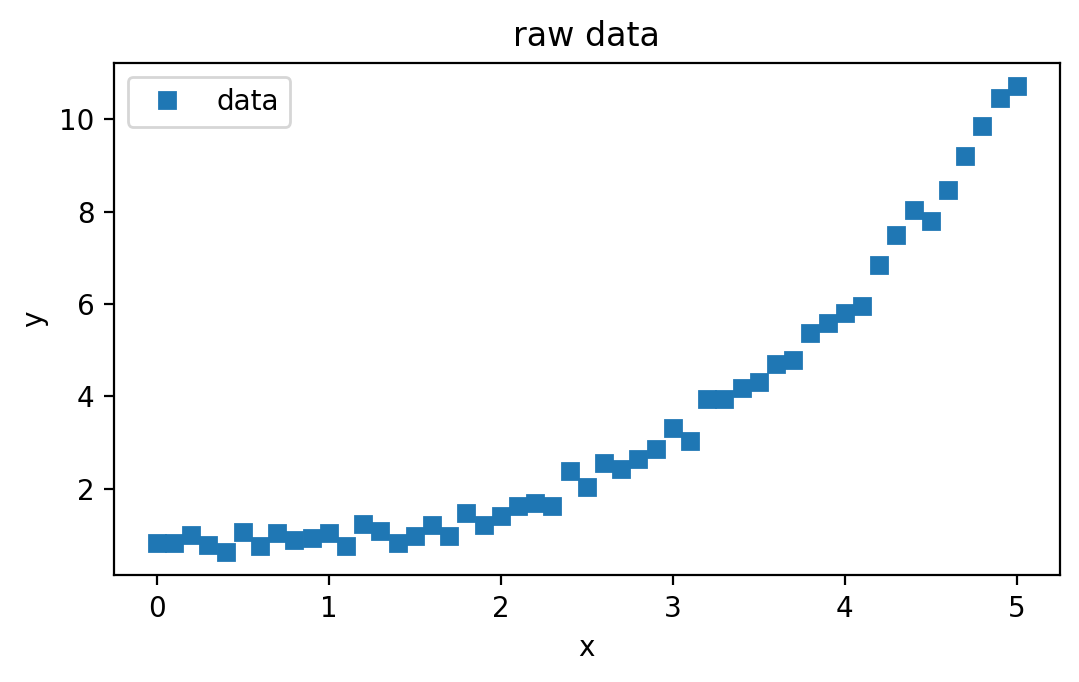

In [7]:
excel_file = 'data/demo-polynomial-2.xlsx'
mydata = pd.read_excel(excel_file)
x = np.array(mydata['x'])
y = np.array(mydata['y'])

classlib4334.plot_raw_data(x, y)

and then immediately modeling this data with quadratic, cubic, and quartic models:

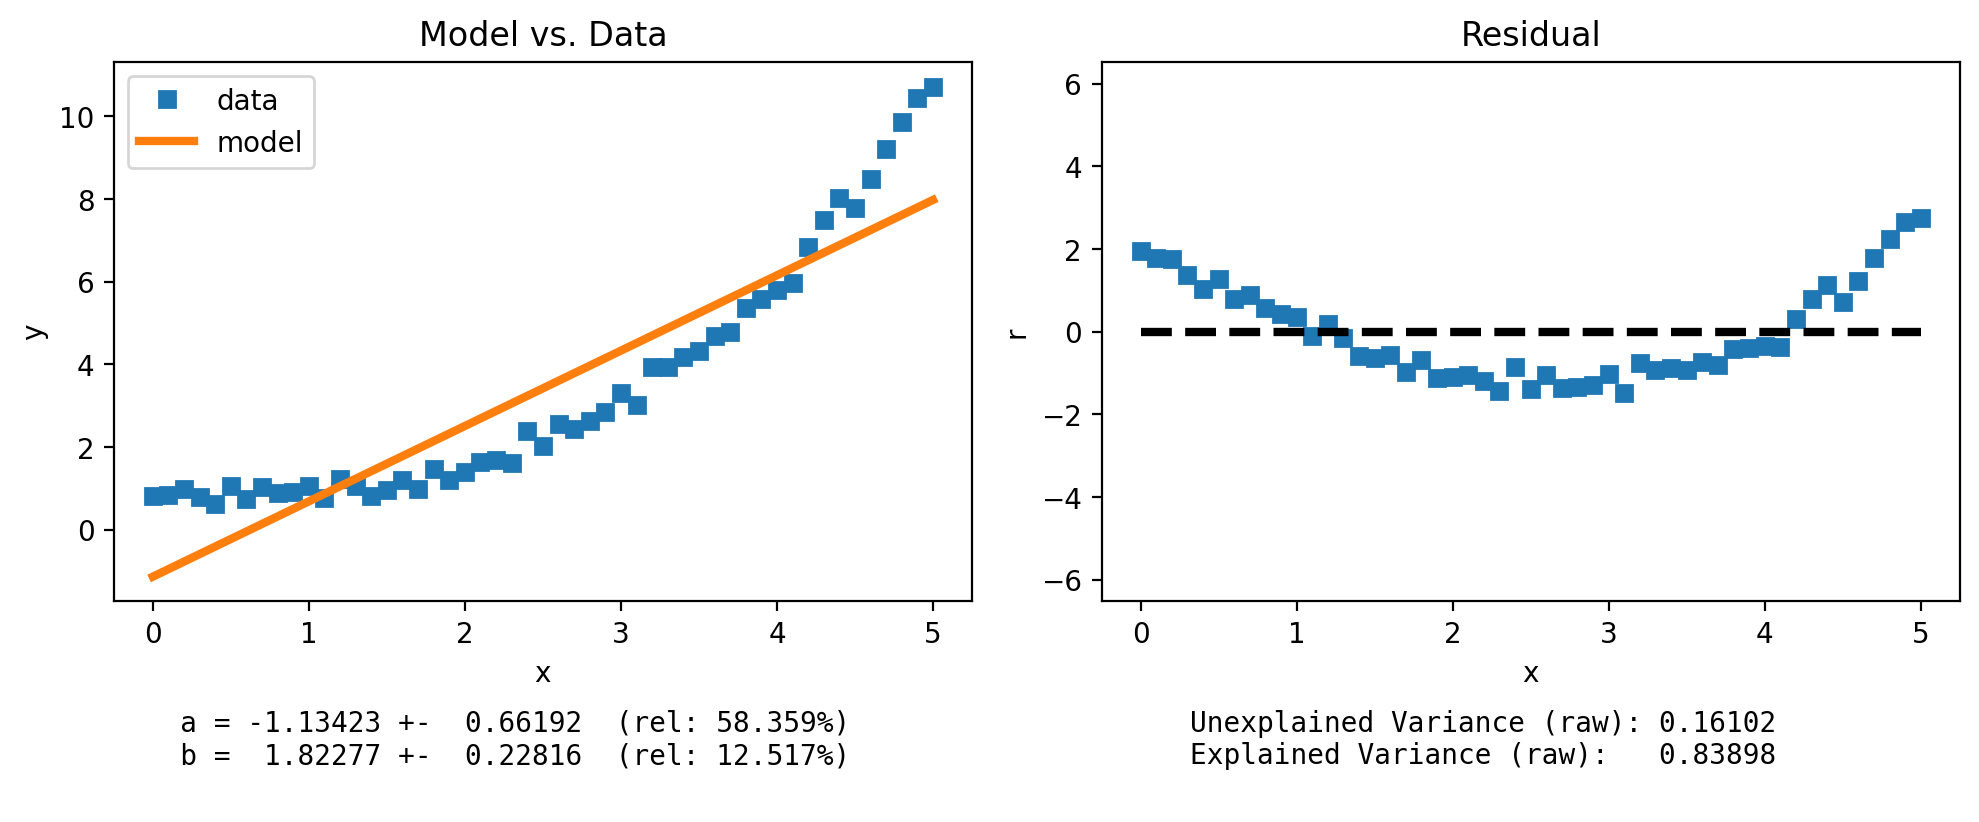

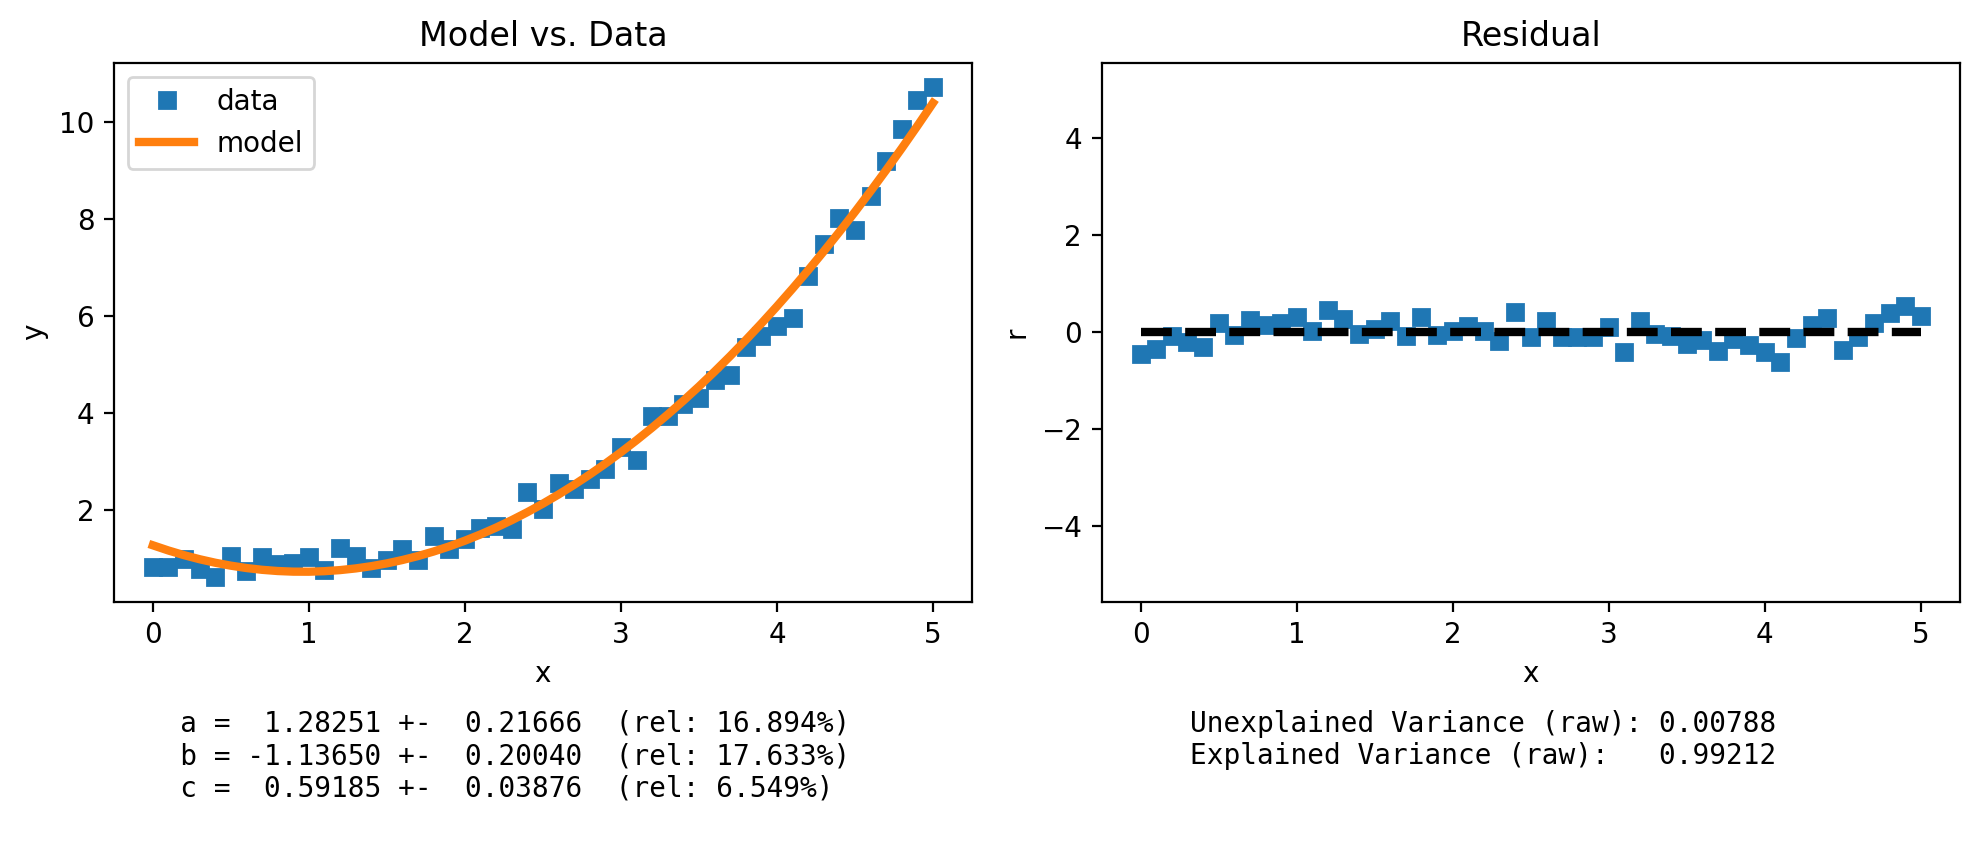

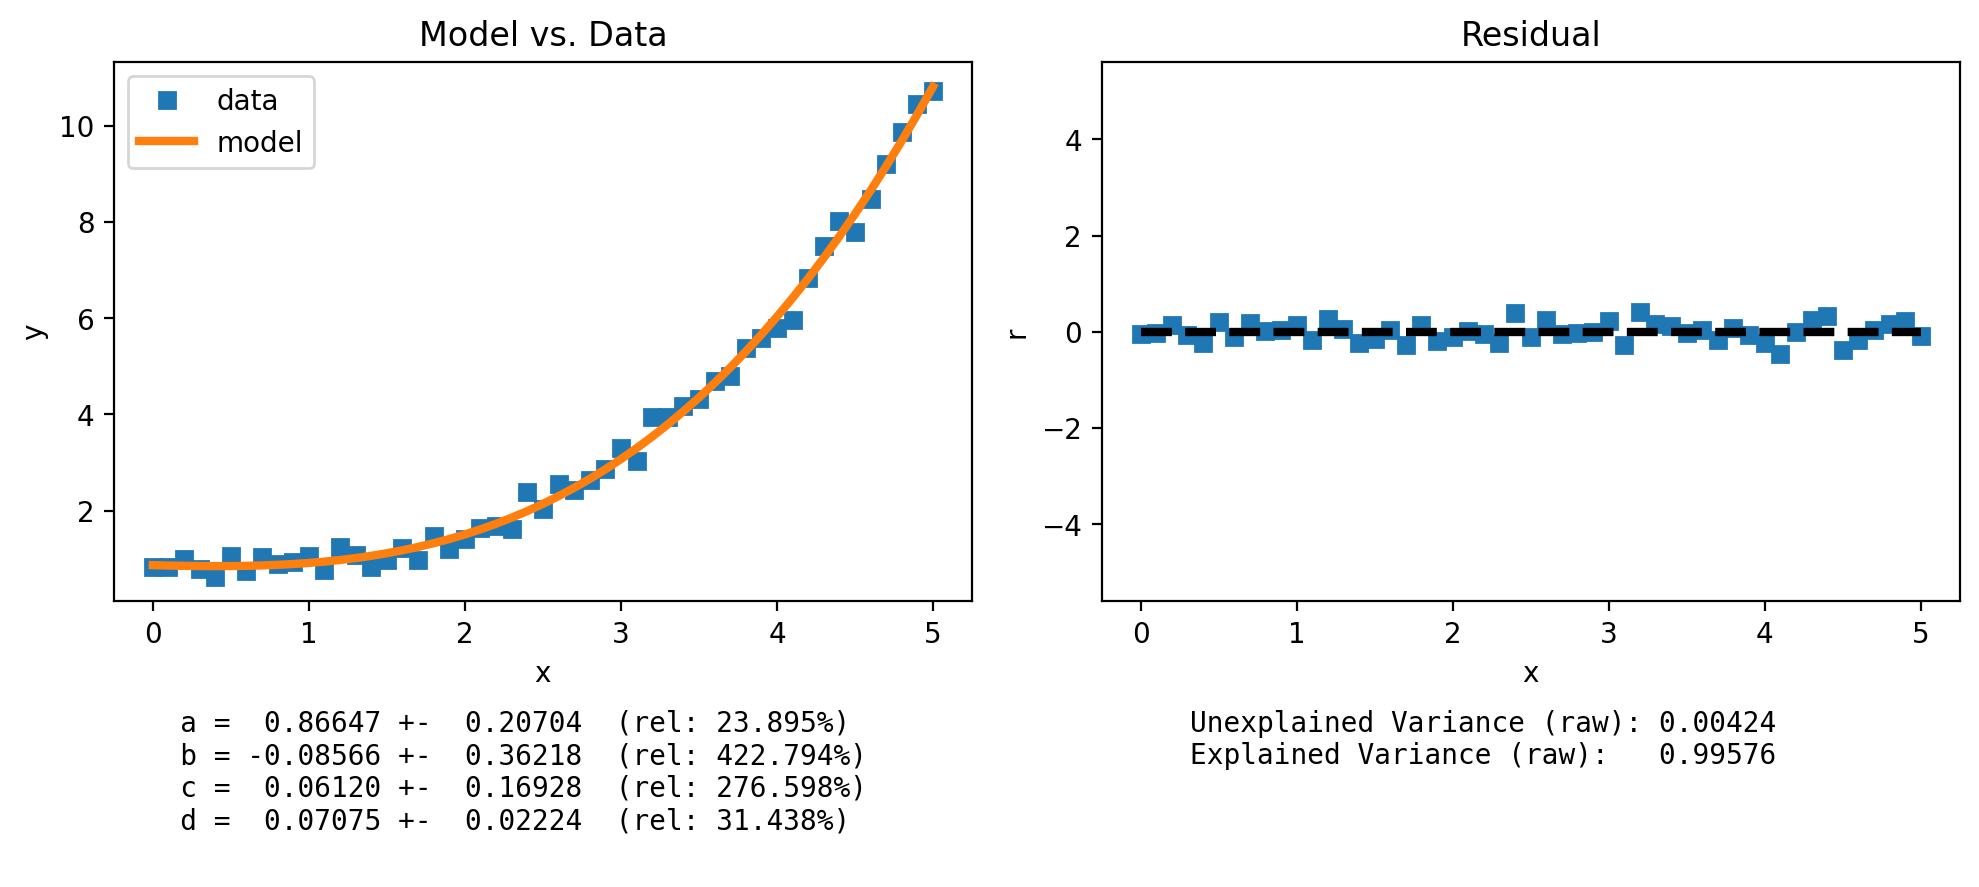

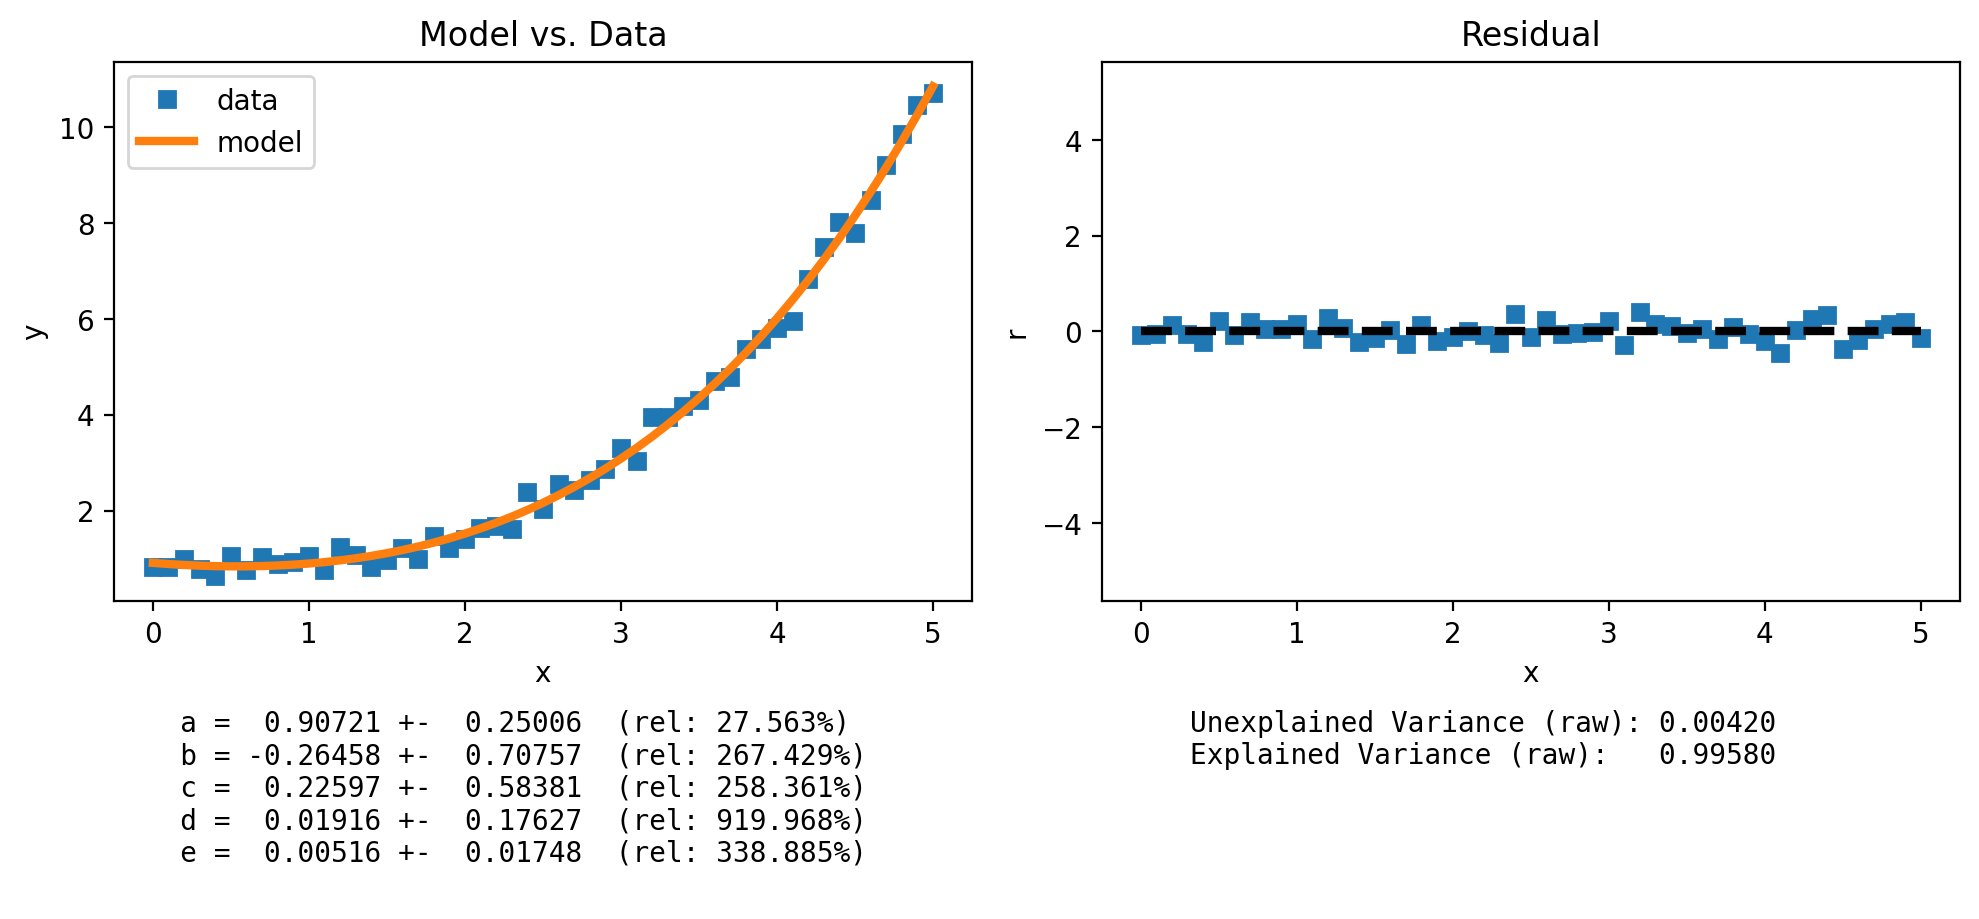

In [69]:
fit1, err1 = classlib4334.fit_and_plot(p1, x, y, residual=True)
fit2, err2 = classlib4334.fit_and_plot(p2, x, y, residual=True)
fit3, err3 = classlib4334.fit_and_plot(p3, x, y, residual=True)
fit4, err4 = classlib4334.fit_and_plot(p4, x, y, residual=True)

We see that the explained variance is increasing with each new term (as expected).  However, the parametric uncertainties are also increasing, and the improvement in the explained variance is not large after the third-order model.  In fact, we can create a plot of the unexplained variance versus the order of the polynomial.  Let's quickly calculate the UVR/EVR for each model:

In [91]:
pvals = [1, 2, 3, 4, 5, 6, 7]
models = [p1, p2, p3, p4, p5, p6, p7]

uvrs = []
evrs = []
for n, f in zip(pvals, models):
    pfit, pcov = opt.curve_fit(f, x, y)
    ymean = np.mean(y)
    ypred = f(x, *pfit)
    ssres = np.sum((y - ypred)**2)
    sstot = np.sum((y - ymean)**2)
    N = len(y)
    P = len(pfit)
    uvr = ssres/sstot
    evr = 1-uvr
    uvrs.append(uvr)
    evrs.append(evr)

and then plot the UVR versus the polynomial order

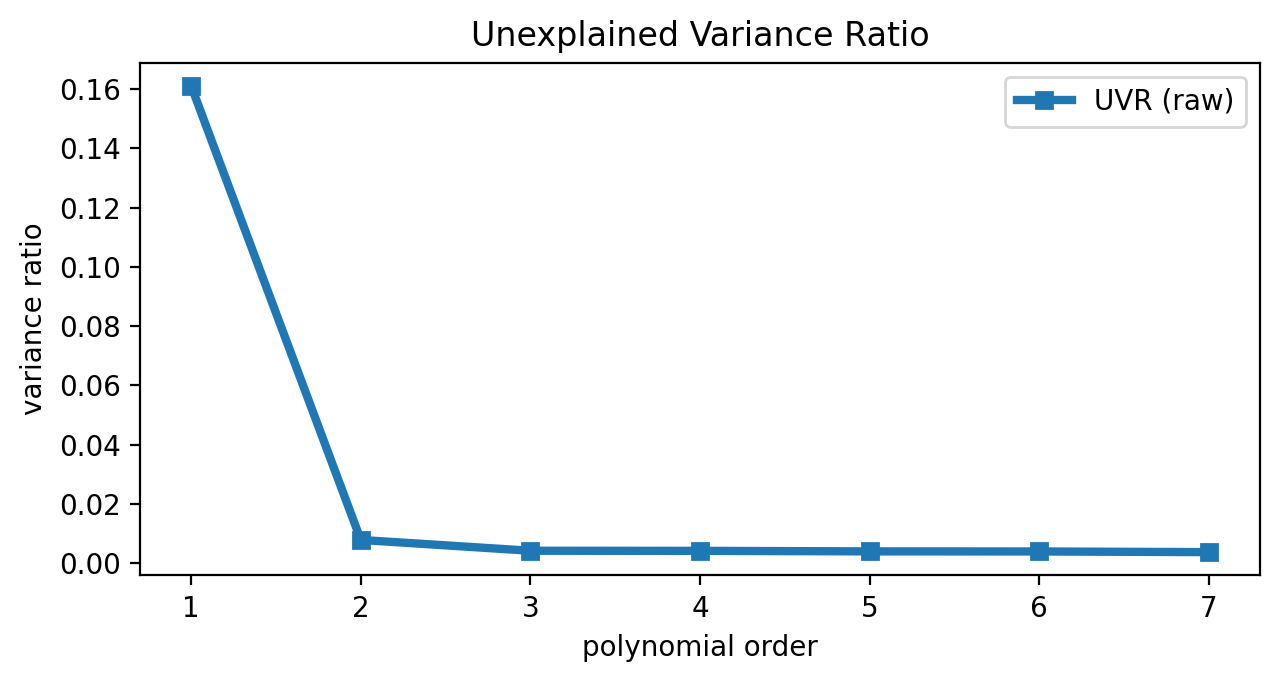

In [92]:
fig, ax = plt.subplots(figsize=(6.5,3.5))
ax.plot(pvals, uvrs, 's-', label="UVR (raw)")
ax.set_xlabel('polynomial order')
ax.set_ylabel('variance ratio')
ax.set_title('Unexplained Variance Ratio')
ax.legend(loc='best')
ax.set_xticks(pvals)
fig.tight_layout()
plt.show()

After the large decrease in UVR between the linear and quadratic models, it is very difficult to see whether the UVR continues decreasing meaningfully.  So let's re-create this plot, but (a) drop the first entry, and (b) use a log scale in the y-direction:

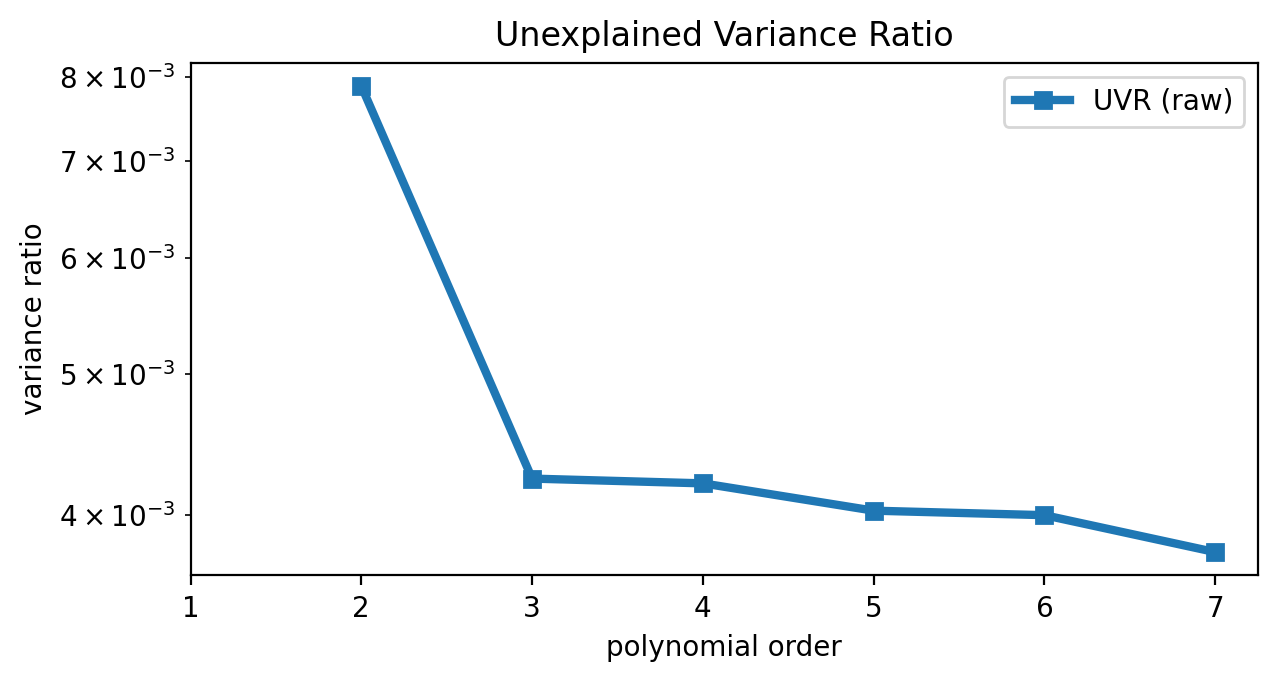

In [81]:
fig, ax = plt.subplots(figsize=(6.5, 3.5))
ax.semilogy(pvals[1:], uvrs[1:], 's-', label="UVR (raw)")
ax.set_xlabel('polynomial order')
ax.set_ylabel('variance ratio')
ax.set_title('Unexplained Variance Ratio')
ax.legend(loc='best')
ax.set_xticks(pvals)
fig.tight_layout()
plt.show()

This reveals meaningful improvement between the quadratic and cubic models (the UVR is cut in half), but very little continued improvement as more terms are added to the model.  This strongly suggests stopping at third degree, but our ultimate goal is **to try and quantify whether the increase in accuracy is "worth" the increase in the number of parameters**.  We will explore two ways in which this question is commonly addressed.

## Adjusted R-squared

The first approach is to *adjust* the quantitative metrics to penalize them for the increase in the number of terms.  The standard way to do this draws on the concept of **degrees of freedom**, which is defined as "the number of data points $N$ minus the number of fit parameters $P$."
$$\mathrm{DOF} = N - P$$

The "Adjusted Unexplained Variance Ratio" is then
$$\mathrm{aUVR} = \frac{ \frac{SS_\mathrm{res}}{DOF_\mathrm{res}}} { \frac{SS_\mathrm{tot}}{DOF_\mathrm{tot}}}$$

And since the "model" for the total residual is the mean value, which is a single constant, we treat the denominator as having one parameter.  This gives the definition
$$\mathrm{aUVR} = \frac{ \frac{SS_\mathrm{res}}{N-P}} { \frac{SS_\mathrm{tot}}{N-1}} = \frac{SS_\mathrm{res}}{SS_\mathrm{tot}} \frac{N-1}{N-P}$$

Similarly, the "Adjusted Explained Variance Ratio," or simply "Adjusted R-squared," is defined via
$$\mathrm{aEVR} = R^2_\mathrm{adj.} - \frac{SS_\mathrm{res}}{SS_\mathrm{tot}} \frac{N-1}{N-P}$$

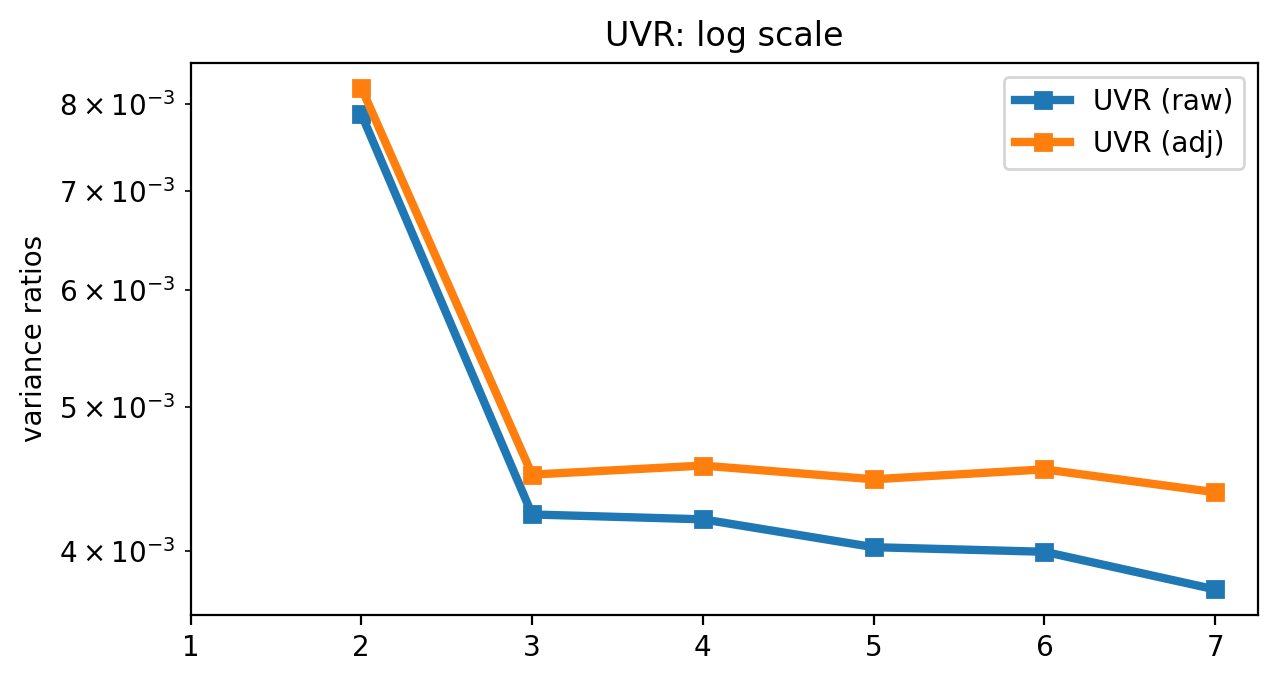

In [80]:
pvals = [1, 2, 3, 4, 5, 6, 7]
models = [p1, p2, p3, p4, p5, p6, p7]

uvrs = []
evrs = []
auvrs = []
aevrs = []
for n, f in zip(pvals, models):
    pfit, pcov = opt.curve_fit(f, x, y)
    ymean = np.mean(y)
    ypred = f(x, *pfit)
    ssres = np.sum((y - ypred)**2)
    sstot = np.sum((y - ymean)**2)
    N = len(y)
    P = len(pfit)
    uvr = ssres/sstot
    evr = 1-uvr
    auvr = uvr*(N-1)/(N-P)
    aevr = 1-auvr
    uvrs.append(uvr)
    evrs.append(evr)
    auvrs.append(auvr)
    aevrs.append(aevr)


fig, ax = plt.subplots(figsize=(6.5,3.5))

ax.semilogy(pvals[1:], uvrs[1:], 's-', label="UVR (raw)")
ax.semilogy(pvals[1:], auvrs[1:], 's-', label="UVR (adj)")
ax.set_ylabel('variance ratios')
ax.set_title('UVR: log scale')
ax.legend(loc='best')
ax.set_xticks(pvals)
fig.tight_layout()
plt.show()

Here, whereas the raw UVR continues decreasing, the adjusted UVR actually increases from the cubic to the quartic polynomial, and remains at about the same value as the order continues increasing.  It would be nice if the adjusted UVR started *increasing* above third order, giving us a nice clear minimum at the cubic.  But it doesn't, and so the adjusted $R^2$ isn't a perfect solution.  This leads to the second approach:

## The Fisher Number

Instead of modifying adjusting the metric for each individual model, the Fisher test looks at differences *between* models.  Specifically, it measures the relative change in UVR -- with respect to relative change in DOF -- between a simple model and a complex model of which the simple model is a "nested" special case.  The formula for the F-number is
$$
F = \frac{\Delta_\mathrm{rel} UVR} {\Delta_\mathrm{rel} DOF}
  = \frac{ \frac{UVR^\mathrm{simple} - UVR^\mathrm{complex}} {UVR^\mathrm{complex}} }
         { \frac{DOF^\mathrm{simple} - DOF^\mathrm{complex}} {DOF^\mathrm{complex}} }$$

Because the more complex model should *always* reduce the unexplained variance, the numerator must be positive.  Similarly, because the more complex model should *always* have more parameters and therefore fewer degrees of freedom, the denominator must be positive.  So this number is guaranteed to be positive.

***As a very general rule of thumb***, we are looking to see whether the F-number is greater or less than one -- that is, whether the relative decrease in UVR is larger or smaller than the relative decrease in DOF.  Interpretation is easy if $F$ is very large or very small.  If $F \gg 1$ then we very confidently prefer the more complex model, whereas if $F \ll 1$ then we very confidently prefer the simpler model.

When $F$ is near one (say, between .333 and 3), then a more nuanced assessment of the situation can be provided by statistics.  By comparing the F-number to the ***Fisher Distribution***, it is possible to obtain another number called the **P-value**, which is the likelihood that the improvement obtained by the more complex model is due to chance.  This will be done for you in helper functions.  A typical threshold at which we would lean toward the more complicated function is $P < .05$.

In [94]:
for n, fs, fc in zip(pvals[1:-2], models[1:-2], models[2:-3]):
    
    spfit, spcov = opt.curve_fit(fs, x, y)
    cpfit, cpcov = opt.curve_fit(fc, x, y)

    ymean  = np.mean(y)
    sypred = fs(x, *spfit)
    cypred = fc(x, *cpfit)
    
    suvr = np.sum((y - sypred)**2) / np.sum((y - ymean)**2)
    cuvr = np.sum((y - cypred)**2) / np.sum((y - ymean)**2)
    sdof = len(y) - len(spfit)
    cdof = len(y) - len(cpfit)

    #print("%d --> %d DOF:  %5.3f --> %5.3f UVR" % (sdof, cdof, suvr, cuvr))
    from scipy import stats
    fnum = ((suvr - cuvr) / cuvr) / ((sdof - cdof) / cdof)
    pval  = stats.f.sf(fnum, sdof-cdof, cdof)
    print("from order %d to %d:  F-number = %7.3f.  P-value = %7.5f." % (n, n+1, fnum, pval))

from order 2 to 3:  F-number =  40.472.  P-value = 0.00000.
from order 3 to 4:  F-number =   0.348.  P-value = 0.55796.


These results show us that between second order and third order, the relative reduction in the residual error is 40 times greater than the relative reduction in degrees of freedom, and that the likelihood of this occuring by chance is effectively zero.  That, in turn, tells us that the cubic term was a very valuable addition, and the more complex cubic model should be strongly preferred over the simpler quadratic model.

On the other hand, between third and fourth order, the ratio of the decrease in relative error over the decrease in relative DOF is considerably smaller than 1, and comparison with the appropriate F-distribution tells us that there is a 55% probability that the increase in accuracy was due to random fluctuations.  These metrics suggest that the (very) minor improvement that we saw in the residual is not worth the additional model complexity.

We conclude -- as before -- that the best model we've seen so far is in fact the cubic model we obtained last time, and it's worth summarizing it:
$$ y = A + Bx + Cx^2 + Dx^3$$
where
$$ A = 0.87 \pm 0.21 $$
$$ B = -0.086 \pm 0.36 $$
$$ C = 0.061 \pm 0.17 $$
$$ D = 0.071 \pm 0.022 $$
with coefficient uncertainties given at the 95% confidence level.

## Revisiting Example 2:  Reduced Models

We have seen how the Adjusted $R^2$ and Fisher numbers can help us identify at what order we should stop.  However, recall that after settling on a third-order model, we also observed that some of the terms within that model were unnecessary.  The two metrics we have just discussed can help us quantify that observation as well.

In [95]:
def p3nob(x, a, c, d):
    return a + c*x**2 + d*x**3

def p3nobnoc(x, a, d):
    return a + d*x**3

pvals = [2, 3, 4]
models = [p3nobnoc, p3nob, p3]

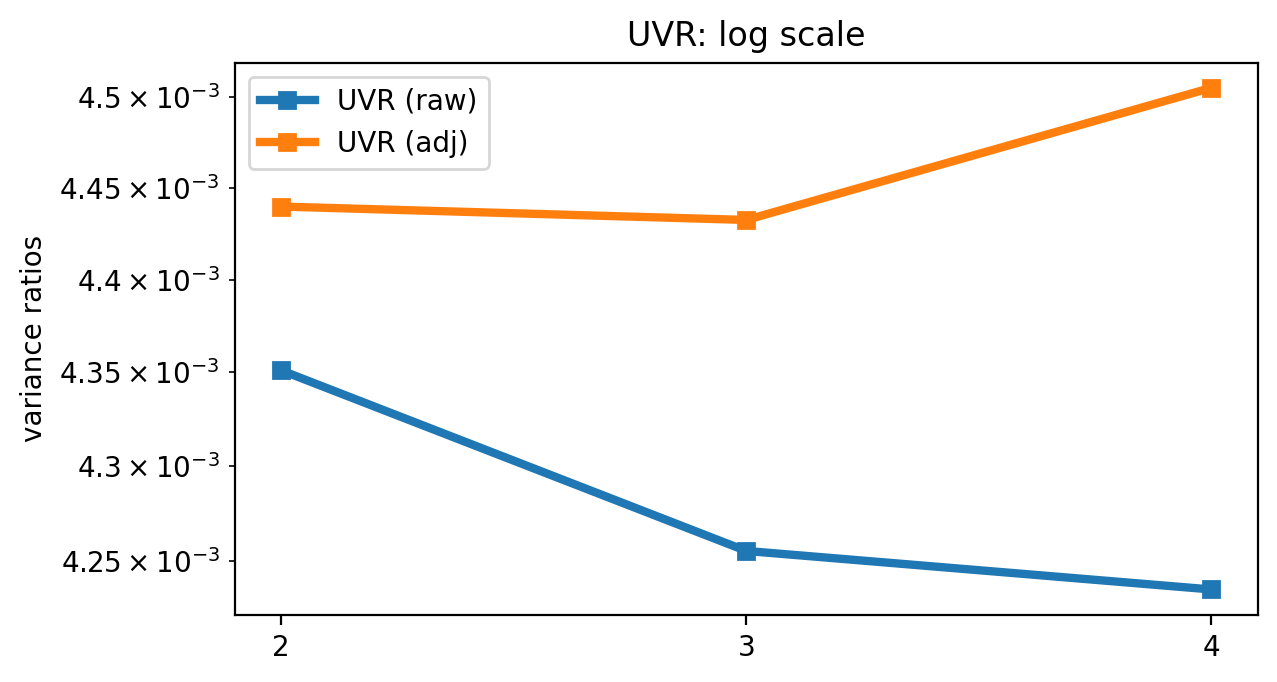

In [96]:
uvrs = []
evrs = []
auvrs = []
aevrs = []
for n, f in zip(pvals, models):
    pfit, pcov = opt.curve_fit(f, x, y)
    ymean = np.mean(y)
    ypred = f(x, *pfit)
    ssres = np.sum((y - ypred)**2)
    sstot = np.sum((y - ymean)**2)
    N = len(y)
    P = len(pfit)
    uvr = ssres/sstot
    evr = 1-uvr
    auvr = uvr*(N-1)/(N-P)
    aevr = 1-auvr
    uvrs.append(uvr)
    evrs.append(evr)
    auvrs.append(auvr)
    aevrs.append(aevr)


fig, ax = plt.subplots(figsize=(6.5,3.5))

ax.semilogy(pvals, uvrs, 's-', label="UVR (raw)")
ax.semilogy(pvals, auvrs, 's-', label="UVR (adj)")
ax.set_ylabel('variance ratios')
ax.set_title('UVR: log scale')
ax.legend(loc='best')
ax.set_xticks(pvals)
fig.tight_layout()
plt.show()

In [90]:
for n, fs, fc in zip(pvals[:-1], models[:-1], models[1:]):
    
    spfit, spcov = opt.curve_fit(fs, x, y)
    cpfit, cpcov = opt.curve_fit(fc, x, y)

    ymean  = np.mean(y)
    sypred = fs(x, *spfit)
    cypred = fc(x, *cpfit)
    
    suvr = np.sum((y - sypred)**2) / np.sum((y - ymean)**2)
    cuvr = np.sum((y - cypred)**2) / np.sum((y - ymean)**2)
    sdof = len(y) - len(spfit)
    cdof = len(y) - len(cpfit)

    #print("%d --> %d DOF:  %5.3f --> %5.3f UVR" % (sdof, cdof, suvr, cuvr))
    from scipy import stats
    fnum = ((suvr - cuvr) / cuvr) / ((sdof - cdof) / cdof)
    pval  = stats.f.sf(fnum, sdof-cdof, cdof)
    print("from %d to %d params:  F-number = %7.3f.  P-value = %7.5f." % (n, n+1, fnum, pval))

from 2 to 3 params:  F-number =   1.081.  P-value = 0.30367.
from 3 to 4 params:  F-number =   0.224.  P-value = 0.63837.


Again, we see that neither of the increases in complexity are justified.  We conclude that the linear and quadratic terms offer no increase in the predictive power of this model for this data set.  If I am able to get just a good of a model with **fewer parameters**, I will choose to do so, under the reasoning of Occam's Razor.  So my final model is

$$ y = A + Dx^3$$
where
$$ A = 0.87 \pm 0.037 $$
$$ D = 0.08 \pm 0.00076 $$
with coefficient uncertainties given at the 95% confidence level.

**IMPORTANT NOTE**:  See how the uncertainties in the fits of $A$ and $D$ actually ***decreased*** compared to model 2 when I removed potentially extraneous terms from my model!

### Epiloge to Exercise 2

If you really want to make your brain hurt, I will now reveal the function I actually used to generate the data:  it was

$$ y = 1.0 - 0.33 x + 0.2 x^2 + 0.05 x^3 + \eta(0.2)$$

This looks meaningfully different than we obtained even in the full cubic model, and the linear and quadradic terms were ***present*** in the data!  What?!?!

This really threw me for a loop at first, but remember that the data were moderately noisy.  The lesson here (familiar to any photography enthusiast) is that ***noise obscures fine-scale structure***.  You may feel that there wasn't *too* much noise in the data, but it was enough to introduce considerable uncertainty into our parameter estimates in the full cubic model, to the point where we concluded the linear and quadratic terms from that model didn't help enough to keep.

In the real world, where your whole goal is to discover a model for the data, you **will not know** the function that generated the data!  You will only have the noisy data, and the noisier it is, the more detail will be undetectable.  So without access to more measurements that could reduce the noise, I stand by the last model we developed as the "best, simplest" model **for the data we were given**.

I'll conclude with a plot containing the data, the final, reduced cubic model, and the generating function.

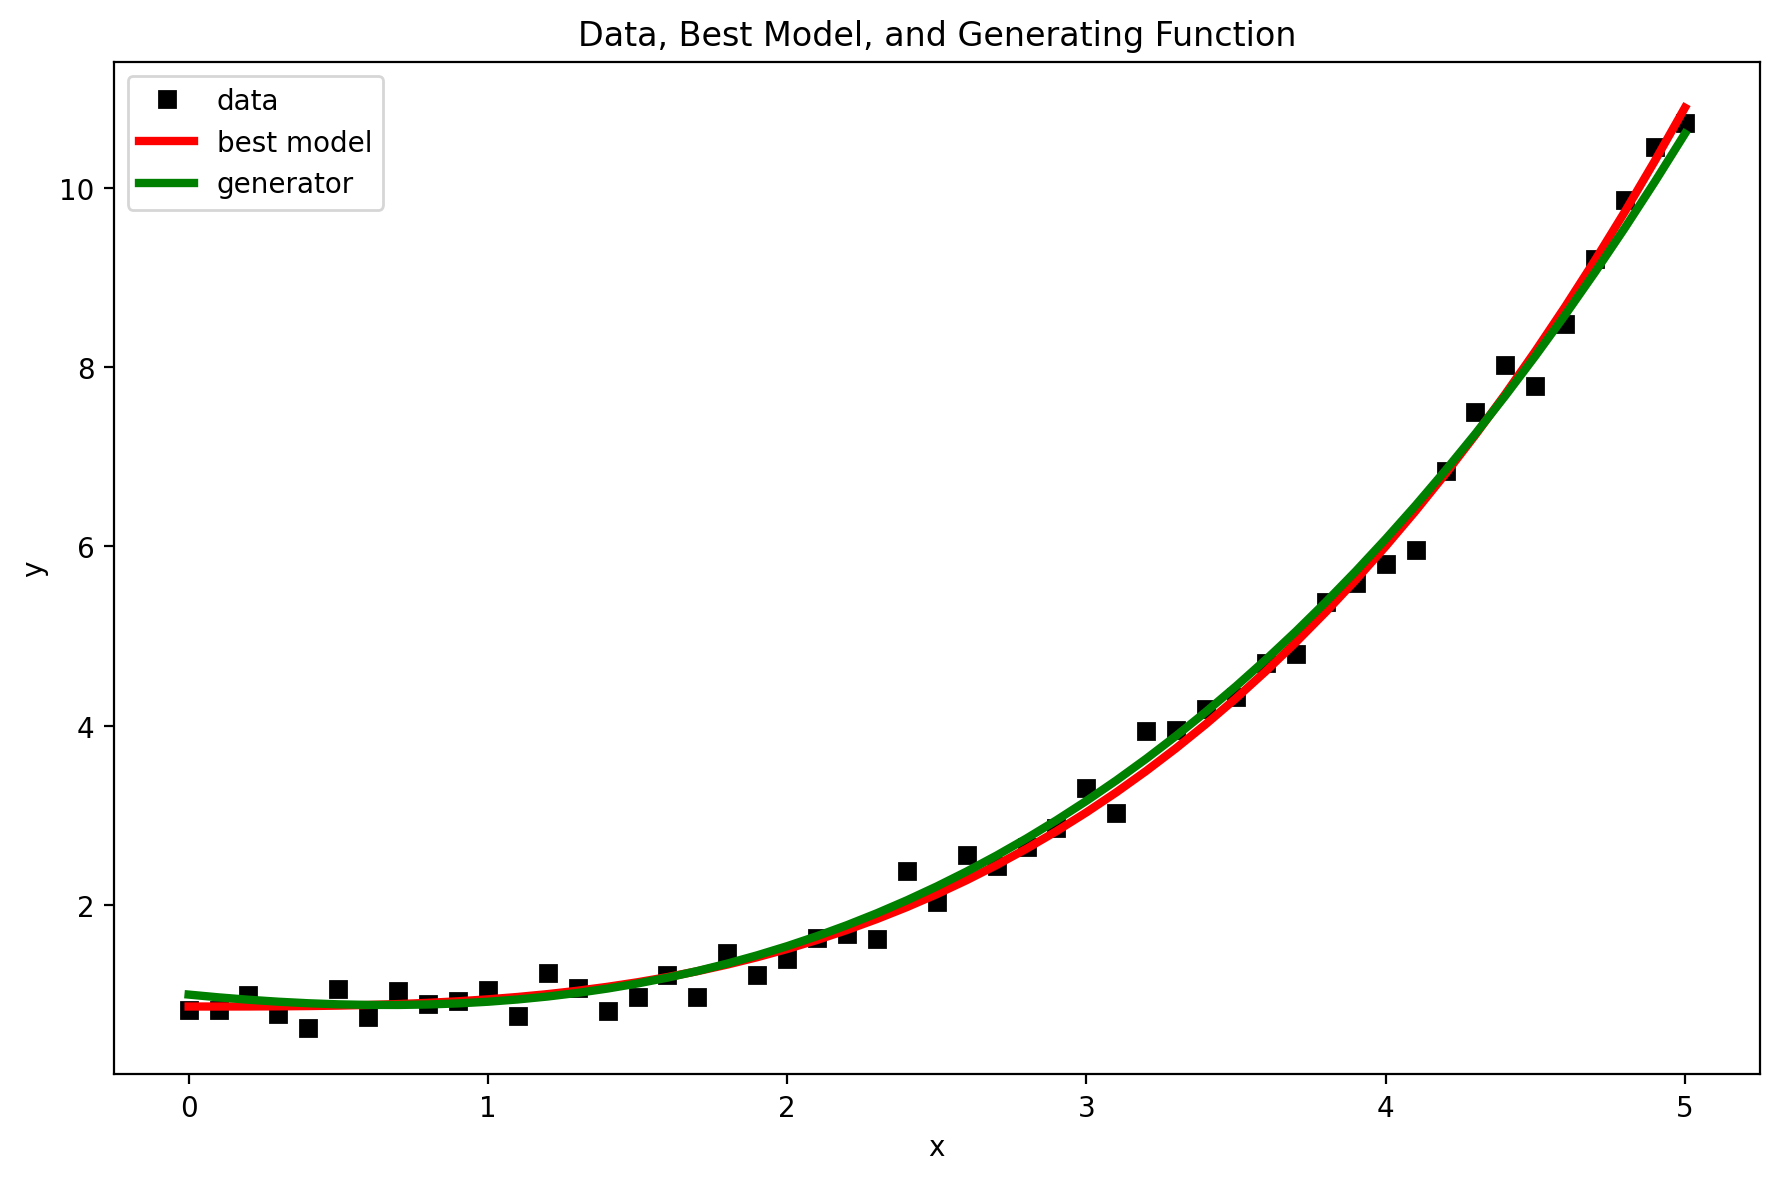

In [100]:
pfit, pcov = opt.curve_fit(p3nobnoc, x, y)
ypred = p3nobnoc(x, *pfit)

plt.figure(figsize=(9,6))
plt.plot(x, y,'ks',label='data')
plt.plot(x, ypred,'r',label='best model')
plt.plot(x, 1.0 - 0.33*x + 0.2*x**2 + 0.05*x**3, 'g', label='generator')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.title('Data, Best Model, and Generating Function')
plt.tight_layout()
plt.show()

# Another Helper Function

In [101]:
fnum, pval = classlib4334.compare_nested(x, y, p3nobnoc, p3)

F-test comparing p3nobnoc (simple) vs. p3 (complex)

  Simple:   SS=1.904018, DOF=  49
  Complex:  SS=1.853256, DOF=  47
  F-number: 0.6437 
  P-value:  0.5299 
  Random?   52.992%

It is recommended to prefer the simple function.

